In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/Output_Files/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_Output_V4.csv')
    ET_DF = Open_File(Diri+Model+'_ET_Output_V4.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V4.csv')
    Storms_DF = Open_File(Diri+Model+'_Storms_Output_V4.csv')
    Time = []
    Start_Time = []
    End_Time = []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Start_Time.append(Datetime(ET_DF["Start Time"][j]))
        End_Time.append(Datetime(ET_DF["End Time"][j]))
    Start_Time_All = []
    End_Time_All = []
    for k in range(len(Storms_DF)):
        Start_Time_All.append(Datetime(Storms_DF["Start Time"][k]))
        if type(Storms_DF["End Time"][k]) == str:
            End_Time_All.append(Datetime(Storms_DF["End Time"][k]))
        else:
            End_Time_All.append(numpy.nan)
    Data_DF["Time(Z)"] = Time
    ET_DF["Start Time"] = Start_Time
    ET_DF["End Time"] = End_Time
    Storms_DF["Start Time"] = Start_Time_All
    Storms_DF["End Time"] = End_Time_All
    return (Data_DF, ET_DF, Codes_DF, Storms_DF)

In [5]:
def Datetime(Time):
    New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    return (New_Time)

In [6]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
VLT_Bins = Create_Bins(-600,600,50)
B_Bins = Create_Bins(-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])

In [7]:
Num_Years = numpy.array([90,93,93])

In [8]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distribution(DF, VLT_Bins, B_Bins):
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VLT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
#
# Count Phase Space Distribution
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                        VLT_B_Count[j][k] += 1
                        VLT_B_Length += 1
                for l in range(len(VLT_Bins)-1):
                    if DF["VUT"][i] > VLT_Bins[l] and DF["VUT"][i] <= VLT_Bins[l+1]:
                        VLT_VUT_Count[j][l] += 1
                        VLT_VUT_Length += 1
#
# Calculate Phase Space Density
    VLT_B_Density = VLT_B_Count / VLT_B_Length * 1000
    VLT_VUT_Density = VLT_VUT_Count / VLT_VUT_Length * 1000
    return (VLT_B_Density, VLT_VUT_Density)

In [9]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var):
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    Densities = Density / 1000.
    Right_Half = Densities[x_Mid:]
    Left_Half = Densities[:x_Mid]
    Q1 = 0
    Q2 = 0
    Q3 = 0
    Q4 = 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    return (Q1, Q2, Q3, Q4)

In [10]:
# Create Function For Colours
Rela_Dist_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Rela_Dist_Bounds = numpy.array([0,1,2.5,5,7.5,10,15,20,25,30,40,50])
# Create Function For Colours
def Dist_Colour(Density, Dist_Colours, Dist_Bounds):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Dist_Colours)-1:
                if Density <= Dist_Bounds[k+1] and Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
            else:
                if Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
    return (Colour)

In [12]:
# Calculate Difference Between Models
def Cyclone_Phase_Diff_New(B_1, VUT_1, B_2, VUT_2):
    B_Diff = Cyclone_Phase_Diff_Smoothing(B_1, B_2)
    VUT_Diff = Cyclone_Phase_Diff_Smoothing(VUT_1, VUT_2)
    return (B_Diff, VUT_Diff)

In [13]:
# Calculate Difference Between Models
def Cyclone_Phase_Diff_Smoothing(Var1, Var2):
    Diff = Var1 - Var2
    Sum = Var1 + Var2
    Diff_Smoothen = numpy.zeros((len(Diff), len(Diff[0])))
    for i in range(len(Diff)):
        F = len(Diff)-1
        for j in range(len(Diff[0])):
            G = len(Diff[0])-1
            if i > 0 and i < F and j > 0 and j < G:
                Orig_Diff = Diff[i][j]
                Orig_Sum = Sum[i][j]
                if Orig_Sum > 0.0001:
                    Surround_Diffs = numpy.array([Diff[i-1][j], Diff[i+1][j], Diff[i][j-1], Diff[i][j+1]])
                    Surround_Sums = numpy.array([Sum[i-1][j], Sum[i+1][j], Sum[i][j-1], Sum[i][j+1]])
                    Total_Sum = numpy.sum(Surround_Sums) + Orig_Sum * 6
                    if Total_Sum > 0.0001:
                        Orig_Ratio = Orig_Sum / Total_Sum
                        Surround_Ratios = Surround_Sums / Total_Sum
                        Ratioed_Diffs = Surround_Diffs * Surround_Ratios
                        Ratioed_Diff = numpy.sum(Ratioed_Diffs)
                        Diff_Smoothen[i][j] = Orig_Diff * Orig_Ratio + Ratioed_Diff * (1-Orig_Ratio)
                    else:
                        Diff_Smoothen[i][j] = Diff[i][j]
                else:
                    Diff_Smoothen[i][j] = 0
            else:
                Diff_Smoothen[i][j] = Diff[i][j]
    return (Diff_Smoothen)

In [14]:
# Create Function of Colours of Cyclone Phase Difference Plots
Rela_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'orange', 'darkorange', 'orangered', 'red']
Rela_Diff_Bounds = numpy.array([-6,-4.5,-3,-1.5,-0.5,0.5,1.5,3,4.5,6])
def Diff_Colour(Diff, Diff_Colours, Diff_Bounds):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [15]:
Control_Data, Control_ET, Control_Codes, Control_Storms = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes, RCP45_Storms = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes, RCP85_Storms = Files_Open("RCP85", Diri)

In [16]:
# Phase Space Distribution For Control Run
Control_VLT_B, Control_VLT_VUT = Phase_Space_Distribution(Control_Data, VLT_Bins, B_Bins)
# Phase Space Distribution For RCP4.5 Run
RCP45_VLT_B, RCP45_VLT_VUT = Phase_Space_Distribution(RCP45_Data, VLT_Bins, B_Bins)
# Phase Space Distribution For RCP8.5 Run
RCP85_VLT_B, RCP85_VLT_VUT = Phase_Space_Distribution(RCP85_Data, VLT_Bins, B_Bins)

In [31]:
# Plot Cyclone Phase Distribution
def Cyclone_Phase_Dist_Plot(Fig, VLT_B, VLT_VUT, VLT_Bins, B_Bins, Bounds, Colours, Model):
# VLT B Distribution
    Axis = Fig.add_subplot(3,2,1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Dist_Colour(VLT_B[j][k], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str('Control Phase Space'), fontsize=15)
# Add Quadrant Percent
#    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B")
#    xloc = [0.88,0.12,0.12,0.88]
#    yloc = [0.88,0.88,0.12,0.12]
#    for q in range(len(Quadrant_Percent)):
#        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
#        transform=Axis.transAxes, fontdict={'size':25},color='black')
# Add Figure Label
    Axis.text(0.05, 0.95, str('(a)'), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(3,2,2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Dist_Colour(VLT_VUT[j][l], Colours, Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str('Control Phase Space'), fontsize=15)
# Add Quadrant Percent
#    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT")
#    for q in range(len(Quadrant_Percent)):
#        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
#        transform=Axis.transAxes, fontdict={'size':25},color='black')
# Add Figure Label
    Axis.text(0.05, 0.95, str('(b)'), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# Colour Bar
    Cbar_Label = 'Density (Per 1000 Data Points)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([-0.6, -0.075, 1, 0.02], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=Cbar_Label, ticks=Bounds, shrink=0.7)

In [32]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Cyclone_Phase_Diff_Plot(Fig, Model_1, Model_2, VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2, VLT_Bins, B_Bins, \
Diff_Bounds, Diff_Colours, Kinen):
# Apply Difference Between Models Function
    VLT_B_Diff, VLT_VUT_Diff = Cyclone_Phase_Diff_New(VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2)
#
# VLT B Distribution
    if Kinen == True:
        Axis = Fig.add_subplot(3,2,3)
    else:
        Axis = Fig.add_subplot(3,2,5)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
#    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_B_1, "B")) - \
#    numpy.array(Phase_Space_Quadrant(VLT_B_2, "B"))
#    xloc = [0.85,0.15,0.15,0.85]
#    yloc = [0.85,0.85,0.15,0.15]
#    for q in range(len(Quadrant_Percent)):
#        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
#        transform=Axis.transAxes, fontdict={'size':25},color='black')
# Add Figure Label
    if Kinen == True:
        Axis.text(0.05, 0.95, str('(c)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
    else:
        Axis.text(0.05, 0.95, str('(e)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# VLT VUT Distribution
    if Kinen == True:
        Axis = Fig.add_subplot(3,2,4)
    else:
        Axis = Fig.add_subplot(3,2,6)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l], Diff_Colours, Diff_Bounds)
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VLT_Bins[l], VLT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
#    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_VUT_1, "VUT")) - \
#    numpy.array(Phase_Space_Quadrant(VLT_VUT_2, "VUT"))
#    for q in range(len(Quadrant_Percent)):
#        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
#        transform=Axis.transAxes, fontdict={'size':25},color='black')
# Add Figure Label
    if Kinen == True:
        Axis.text(0.05, 0.95, str('(d)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
    else:
        Axis.text(0.05, 0.95, str('(f)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# Colour Bar
    if Kinen == True:
        Cbar_Label = 'Density Difference (Per 1000 Data Points)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
        Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
        Cax = Axis.inset_axes([-0.6, -0.075, 1, 0.02], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
        label=Cbar_Label, ticks=Diff_Bounds, shrink=0.7)

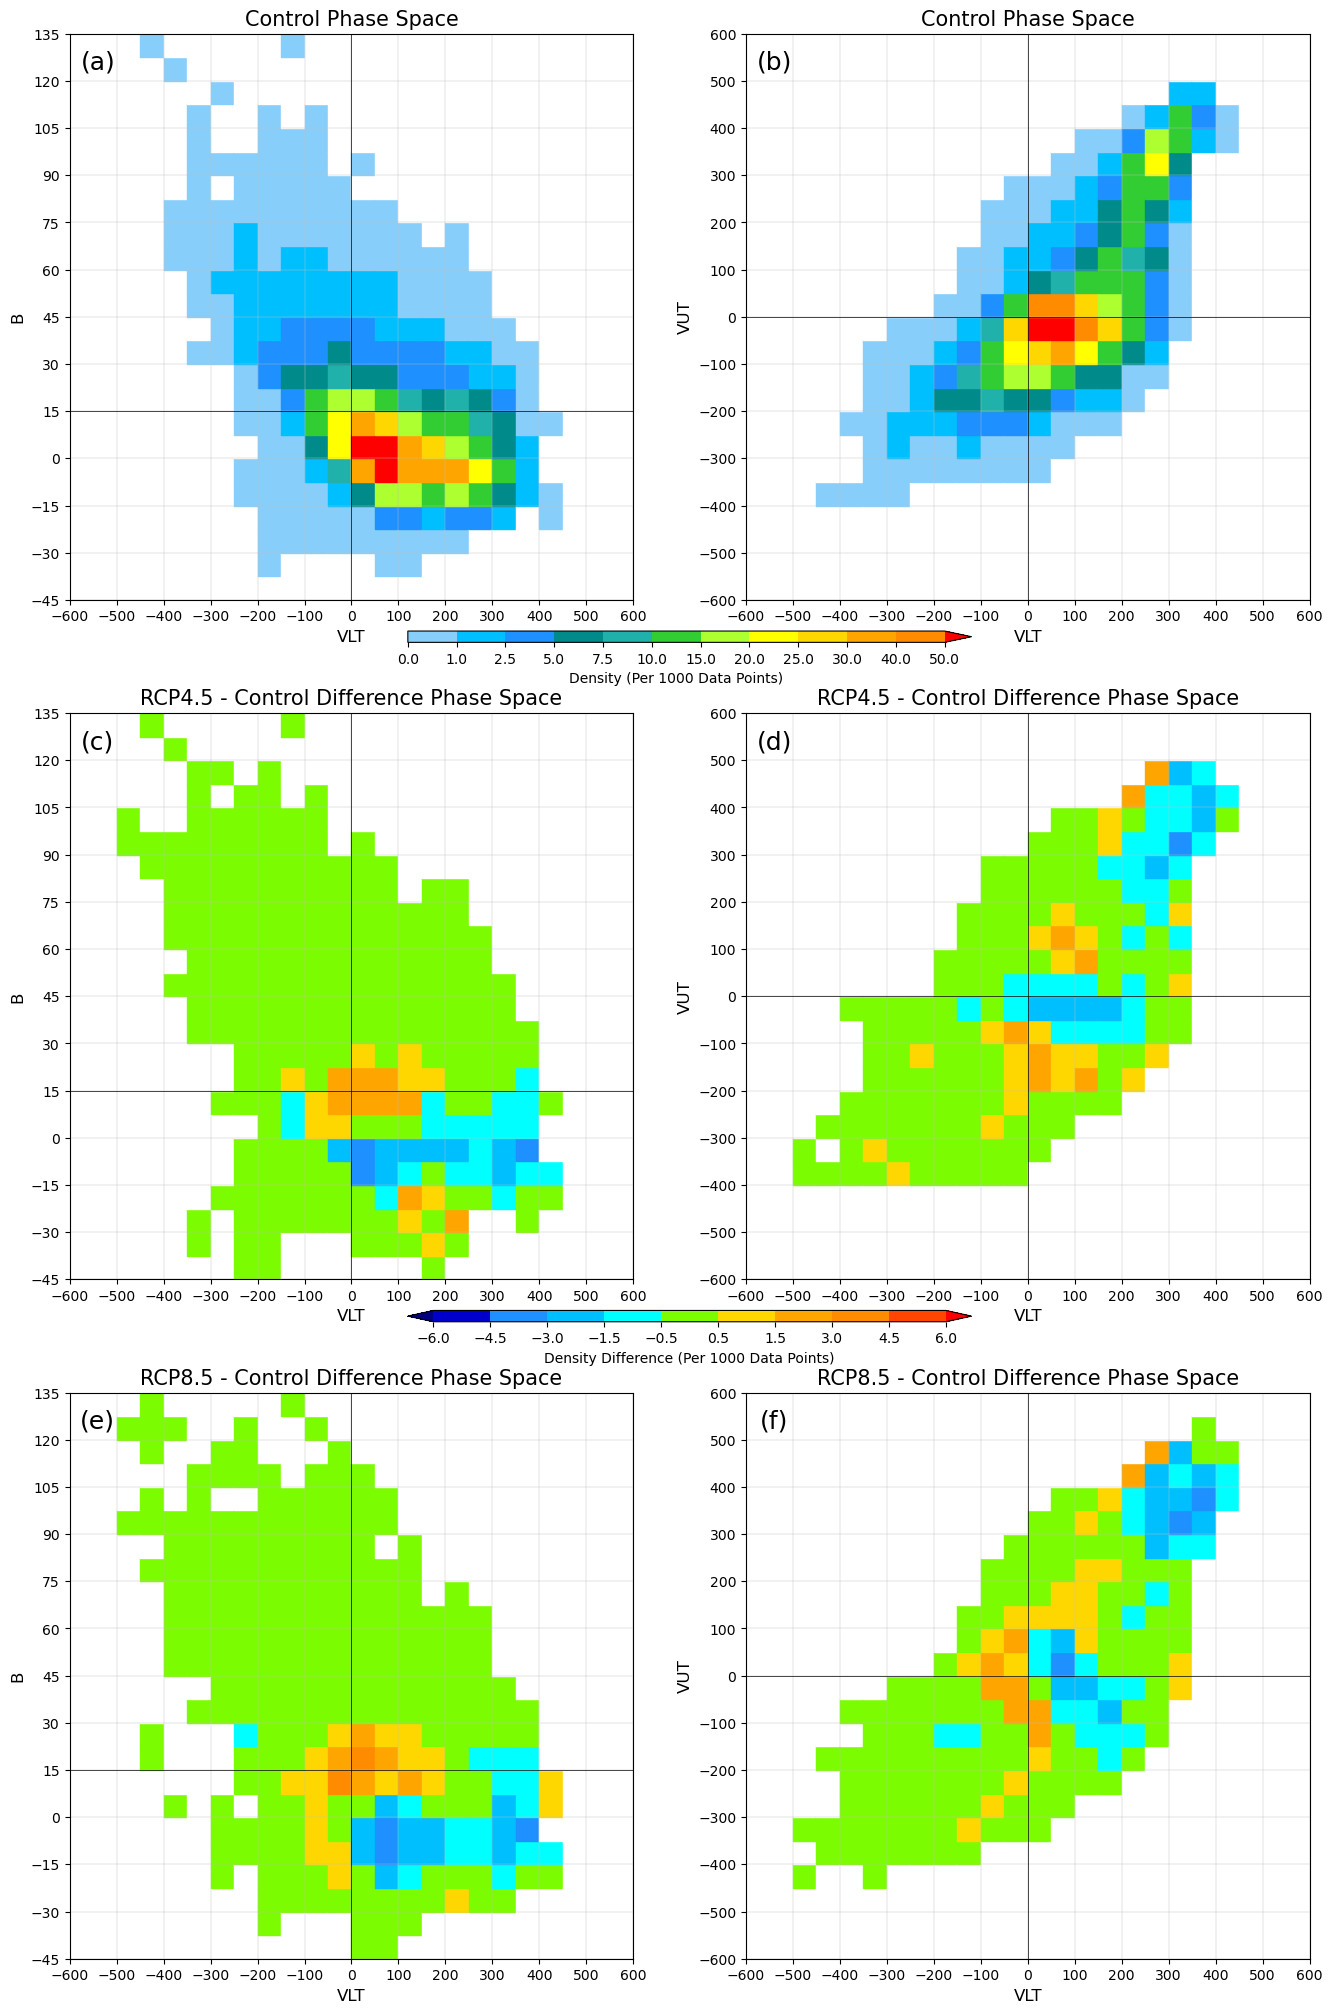

In [33]:
Fig = pyplot.figure(figsize=(16,25))
Cyclone_Phase_Dist_Plot(Fig, Control_VLT_B, Control_VLT_VUT, VLT_Bins, B_Bins, \
Rela_Dist_Bounds, Rela_Dist_Colours, "Control")
#
Cyclone_Phase_Diff_Plot(Fig, "RCP4.5", "Control", RCP45_VLT_B, RCP45_VLT_VUT, Control_VLT_B, Control_VLT_VUT, \
VLT_Bins, B_Bins, Rela_Diff_Bounds, Rela_Diff_Colours, True)
#
Cyclone_Phase_Diff_Plot(Fig, "RCP8.5", "Control", RCP85_VLT_B, RCP85_VLT_VUT, Control_VLT_B, Control_VLT_VUT, \
VLT_Bins, B_Bins, Rela_Diff_Bounds, Rela_Diff_Colours, False)
#
Figname = str('A_Phase_Space_Dist.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')

In [34]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)
Lon_Bins = Create_Bins(-100,20,5)
Lat_Bins = Create_Bins(10,60,5)

In [35]:
def Plot_Map_Formatting(Axis):
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    x_Min = -100
    x_Max = 20
    y_Min = 10
    y_Max = 60
    x_Axis = Create_Bins(x_Min, x_Max, 10)
    y_Axis = Create_Bins(y_Min, y_Max, 10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')

In [36]:
Lengths = numpy.zeros(3)
Lengths[0] = len(Control_ET)
Lengths[1] = len(RCP45_ET)
Lengths[2] = len(RCP85_ET)
#Lengths

In [37]:
# Create Function to Calculate Spatial Distribution of B Value
def ET_Locations_Distribution(ET_DF, Start, Length):
    Lon_Bins = Create_Bins(-100,20,5)
    Lat_Bins = Create_Bins(10,60,5)
    Lat_Lon_Count = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
#
# Count Lat Lon Distribution in Each Gridbox
    if Start == True:
        Lats = ET_DF["Start Lat"]
        Lons = ET_DF["Start Lon"]
    else:
        Lats = ET_DF["End Lat"]
        Lons = ET_DF["End Lon"]
    for i in range(len(Lats)):
        for j in range(len(Lat_Bins)-1):
            if Lats[i] >= (Lat_Bins[j]-5) and Lats[i] <= (Lat_Bins[j+1]+5):
                for k in range(len(Lon_Bins)-1):
                    if Lons[i] >= (Lon_Bins[k]-5) and Lons[i] <= (Lon_Bins[k+1]+5):
                        Lat_Lon_Count[j][k] += 1
#    if Absolute == True:
#        return (Lat_Lon_Count)
#    else:
    Lat_Lon_Density = Lat_Lon_Count / Length / 90 * 10000
    return (Lat_Lon_Density)

In [38]:
# Create Function For Spatial Distribution Count Colours
Spatial_Density_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Spatial_Density_Bounds = numpy.array([0,1,2,3,4,6,8,10,12,15,20,25])
#
def Spatial_Count_Colour(Count, Bounds, Colours):
    for k in range(len(Colours)):
        if Count == 0:
            Colour = 'white'
        else:
            if k != len(Colours)-1:
                if Count > Bounds[k] and Count <= Bounds[k+1]:
                    Colour = Colours[k]
            else:
                if Count > Bounds[k]:
                    Colour = Colours[k]
    return (Colour)

In [39]:
# Calculate Difference Between Models
def Spatial_Diff_New(Var_1, Var_2):
    Diff = Spatial_Diff_Smoothing(Var_1, Var_2)
    return (Diff)

In [40]:
# Calculate Difference Between Models
def Spatial_Diff_Smoothing(Var1, Var2):
    Diff = Var1 - Var2
    Sum = Var1 + Var2
    Diff_Smoothen = numpy.zeros((len(Diff), len(Diff[0])))
    for i in range(len(Diff)):
        F = len(Diff)-1
        for j in range(len(Diff[0])):
            G = len(Diff[0])-1
            if i > 0 and i < F and j > 0 and j < G:
                Orig_Diff = Diff[i][j]
                Orig_Sum = Sum[i][j]
                if Orig_Sum > 0.0001:
                    Surround_Diffs = numpy.array([Diff[i-1][j], Diff[i+1][j], Diff[i][j-1], Diff[i][j+1]])
                    Surround_Sums = numpy.array([Sum[i-1][j], Sum[i+1][j], Sum[i][j-1], Sum[i][j+1]])
                    Total_Sum = numpy.sum(Surround_Sums) + Orig_Sum * 6
                    if Total_Sum > 0.0001:
                        Orig_Ratio = Orig_Sum / Total_Sum
                        Surround_Ratios = Surround_Sums / Total_Sum
                        Ratioed_Diffs = Surround_Diffs * Surround_Ratios
                        Ratioed_Diff = numpy.sum(Ratioed_Diffs)
                        Diff_Smoothen[i][j] = Orig_Diff * Orig_Ratio + Ratioed_Diff * (1-Orig_Ratio)
                    else:
                        Diff_Smoothen[i][j] = Diff[i][j]
                else:
                    Diff_Smoothen[i][j] = 0
            else:
                Diff_Smoothen[i][j] = Diff[i][j]
    return (Diff_Smoothen)

In [41]:
Spatial_Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'cyan', 'lawngreen', \
'gold', 'orange', 'darkorange', 'orangered', 'red']
Spatial_Diff_Bounds = numpy.array([-4,-3,-2,-1,-0.3,0.3,1,2,3,4])
def Spatial_Diff_Colour(Diff, Bounds, Colours):
    for k in range(len(Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff <= Bounds[k]:
                    Colour = Colours[k]
            elif k < len(Colours)-1:
                if Diff <= Bounds[k] and Diff > Bounds[k-1]:
                    Colour = Colours[k]
            else:
                if Diff > Bounds[k-1]:
                    Colour = Colours[k]
    return (Colour)

In [44]:
Control_ET_Start_Density = ET_Locations_Distribution(Control_ET, True, Lengths[0])
RCP45_ET_Start_Density = ET_Locations_Distribution(RCP45_ET, True, Lengths[1])
RCP85_ET_Start_Density = ET_Locations_Distribution(RCP85_ET, True, Lengths[2])

In [45]:
Control_ET_End_Density = ET_Locations_Distribution(Control_ET, False, Lengths[0])
RCP45_ET_End_Density = ET_Locations_Distribution(RCP45_ET, False, Lengths[1])
RCP85_ET_End_Density = ET_Locations_Distribution(RCP85_ET, False, Lengths[2])

In [95]:
# Create Function to Plot ET Start and End Locations
def Plot_ET_Dist(Spatial_Start, Spatial_End, Model, Bounds, Colours):
    Lon_Bins = Create_Bins(-100,20,5)
    Lat_Bins = Create_Bins(10,60,5)
#
# Plot ET Start Data
    Axis = Fig.add_subplot(3,2,1, projection=ccrs.PlateCarree())
    for j in range(len(Spatial_Start)):
        for k in range(len(Spatial_Start[0])):
            Colour = Spatial_Count_Colour(Spatial_Start[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model + " ET Initiation Spatial Distribution"
    Axis.set_title(Title, fontsize=15)
# Add Figure Label
    Axis.text(0.03, 0.95, str('(a)'), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# Colour Bar
    Cbar_Label = 'Relative Frequency (Per 10000 Data Points)'
    C_Map = mcolors.LinearSegmentedColormap.from_list("Relative Frequency of Locations", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([0.1, -0.15, 0.8, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
    label=Cbar_Label)
#
# Plot ET End Data
    Axis = Fig.add_subplot(3,2,2, projection=ccrs.PlateCarree())
    for j in range(len(Spatial_End)):
        for k in range(len(Spatial_End[0])):
            Colour = Spatial_Count_Colour(Spatial_End[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model + " ET Completion Spatial Distribution"
    Axis.set_title(Title, fontsize=15)
# Add Figure Label
    Axis.text(0.03, 0.95, str('(b)'), ha='center', va='center', \
    transform=Axis.transAxes, fontdict={'size':18},color='black')

In [96]:
# Create Function to Plot ET Start and End Locations
def Plot_ET_Dist_Diff(Start_1, Start_2, End_1, End_2, Model_1, Model_2, Bounds, Colours, Kinen):
# Apply Difference Between Models Function
    Start_Diff = Spatial_Diff_New(Start_1, Start_2)
    End_Diff = Spatial_Diff_New(End_1, End_2)
#        print (Diff)
#
# Plot ET Start Data
    if Kinen == True:
        Axis = Fig.add_subplot(3,2,3, projection=ccrs.PlateCarree())
    else:
        Axis = Fig.add_subplot(3,2,5, projection=ccrs.PlateCarree())
    Lon_Bins = Create_Bins(-100,20,5)
    Lat_Bins = Create_Bins(10,60,5)
    for j in range(len(Start_Diff)):
        for k in range(len(Start_Diff[0])):
            Colour = Spatial_Diff_Colour(Start_Diff[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model_1 + " - " + Model_2 + " Difference in ET Initiation Spatial Distribution"
    Axis.set_title(Title, fontsize=15)
# Add Figure Label
    if Kinen == True:
        Axis.text(0.03, 0.95, str('(c)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
    else:
        Axis.text(0.03, 0.95, str('(e)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
#
# Colour Bar
    if Kinen == True:
        Cbar_Label = 'Relative Frequency Difference (Per 10000 Data Points)'
        C_Map = mcolors.LinearSegmentedColormap.from_list("Relative Frequency of Locations", Colours, N=len(Colours))
        Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
        Cax = Axis.inset_axes([0.1, -0.15, 0.8, 0.05], transform=Axis.transAxes)
        Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, ticks=Bounds, \
        label=Cbar_Label)
#
# Plot ET End Data
    if Kinen == True:
        Axis = Fig.add_subplot(3,2,4, projection=ccrs.PlateCarree())
    else:
        Axis = Fig.add_subplot(3,2,6, projection=ccrs.PlateCarree())
    for j in range(len(End_Diff)):
        for k in range(len(End_Diff[0])):
            Colour = Spatial_Diff_Colour(End_Diff[j][k], Bounds, Colours)
            pyplot.fill_between([Lon_Bins[k], Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    Plot_Map_Formatting(Axis)
    Title = Model_1 + " - " + Model_2 + " Difference in ET Completion Spatial Distribution"
    Axis.set_title(Title, fontsize=15)
# Add Figure Label
    if Kinen == True:
        Axis.text(0.03, 0.95, str('(d)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')
    else:
        Axis.text(0.03, 0.95, str('(f)'), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':18},color='black')

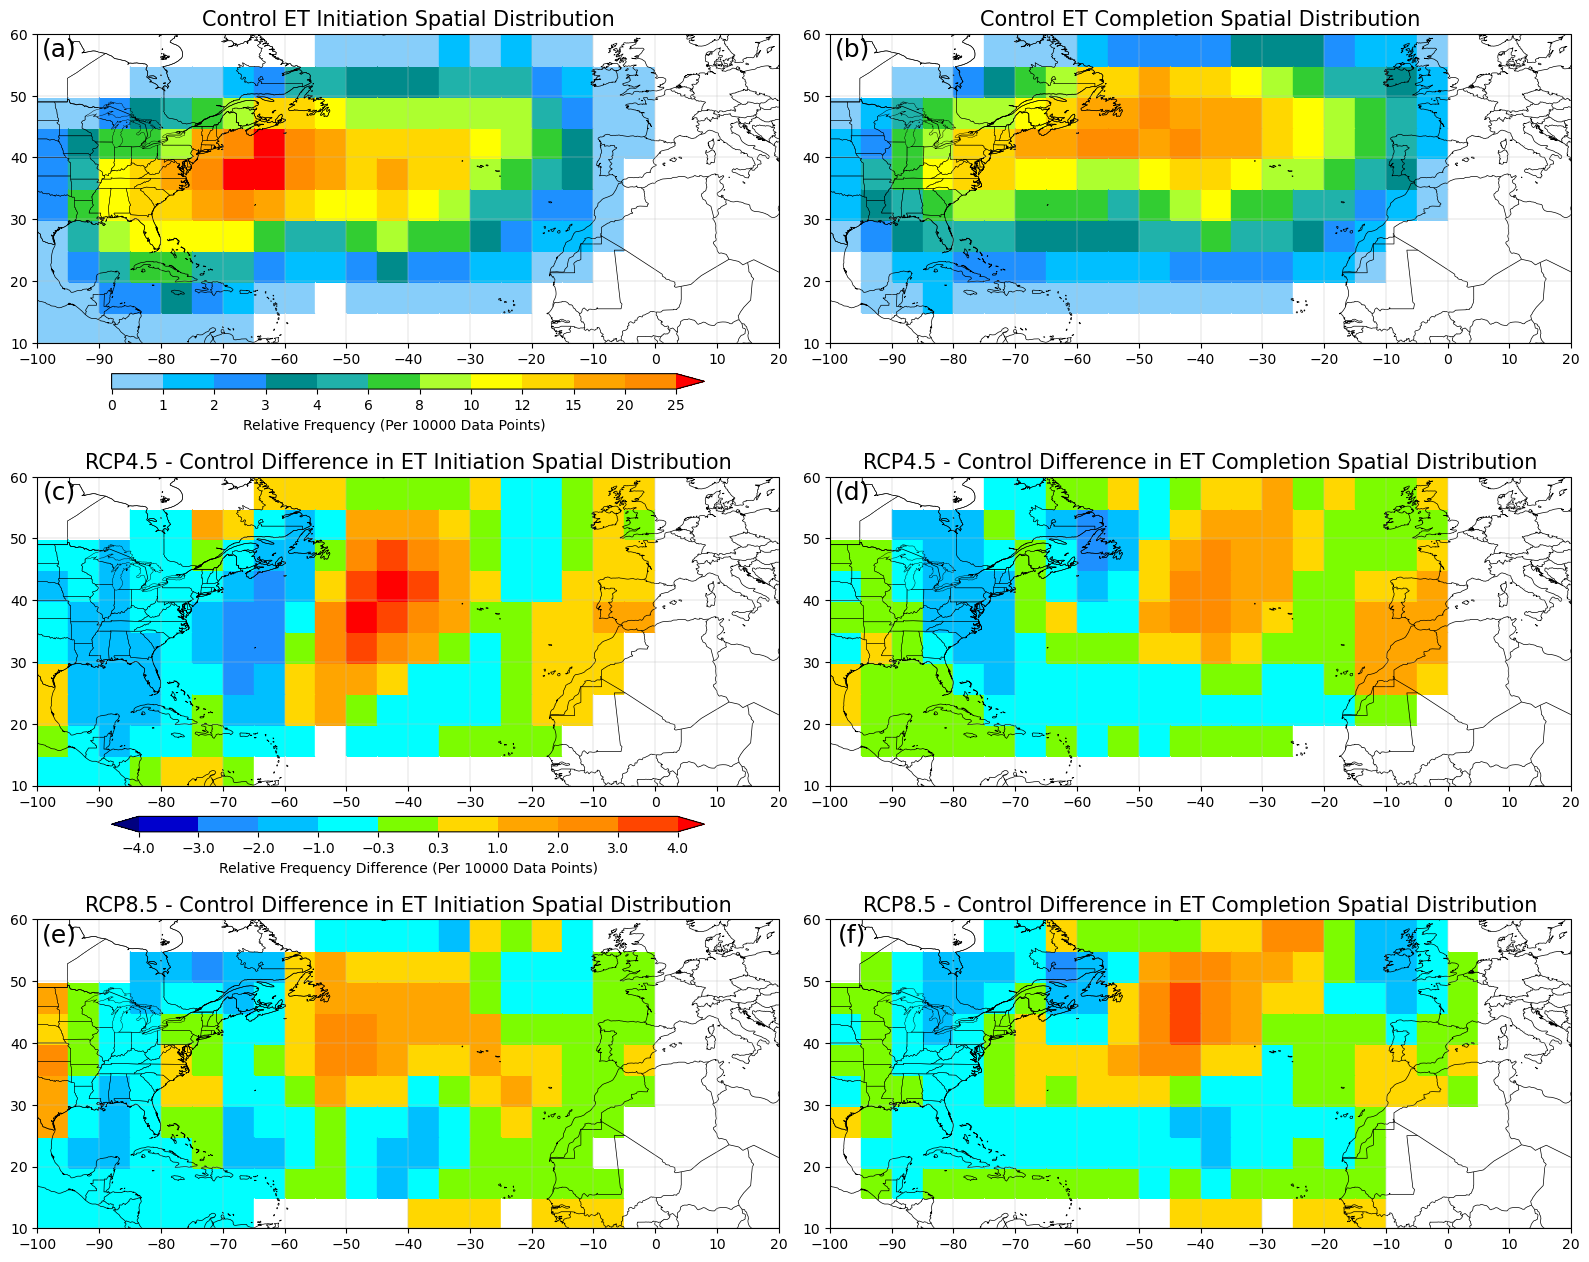

In [97]:
Fig = pyplot.figure(figsize=(16,13))
Plot_ET_Dist(Control_ET_Start_Density, Control_ET_End_Density, "Control", \
Spatial_Density_Bounds, Spatial_Density_Colours)
#
Plot_ET_Dist_Diff(RCP45_ET_Start_Density, Control_ET_Start_Density, RCP45_ET_End_Density, \
Control_ET_End_Density, "RCP4.5", "Control", Spatial_Diff_Bounds, Spatial_Diff_Colours, True)
#
Plot_ET_Dist_Diff(RCP85_ET_Start_Density, Control_ET_Start_Density, RCP85_ET_End_Density, \
Control_ET_End_Density, "RCP8.5", "Control", Spatial_Diff_Bounds, Spatial_Diff_Colours, False)
pyplot.tight_layout()
#
Figname = str('A_Spatial_Dist.png')
Fig.savefig('/glade/u/home/whimkao//ExtraTrack/Analysis_Figs_V4/'+Figname, bbox_inches='tight')